# Week 2 and 3: End-to-end Supervised Learning Project (Regression)

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

"""
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
"""

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. Get the Data

First of all let's import the data from the CSV file.

In [2]:
filepath = os.path.abspath(os.path.join('datasets', 'kings_county_house_data.csv'))
print('File path: {}'.format(filepath))
housing = pd.read_csv(filepath, dtype={'zipcode': str})

File path: D:\Python\P4DS\datasets\kings_county_house_data.csv


We can get an overall idea of the fields available using the `DataFrame.info()` and `DataFrame.describe()` methods.

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null object
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(2)
memory usage: 3.5+ MB


In [4]:
housing.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
mean,4580301520.865,540088.142,3.371,2.115,2079.900,15106.968,1.494,0.008,0.234,3.409,7.657,1788.391,291.509,1971.005,84.402,47.560,-122.214,1986.552,12768.456
std,2876565571.312,367127.196,0.930,0.770,918.441,41420.512,0.540,0.087,0.766,0.651,1.175,828.091,442.575,29.373,401.679,0.139,0.141,685.391,27304.180
min,1000102.000,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,1900.000,0.000,47.156,-122.519,399.000,651.000
25%,2123049194.000,321950.000,3.000,1.750,1427.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,1951.000,0.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,47.572,-122.230,1840.000,7620.000
75%,7308900445.000,645000.000,4.000,2.500,2550.000,10688.000,2.000,0.000,0.000,4.000,8.000,2210.000,560.000,1997.000,0.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,2015.000,2015.000,47.778,-121.315,6210.000,871200.000


## 2. Create a Test Set

Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside. We will use a function from `scikit-learn` which splits a dataset into training and test set.

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [6]:
train_set.shape, test_set.shape

((17290, 21), (4323, 21))

In this way we would just be doing a simple randomized sampling. But this might not be a representative sampling of the whole dataset, if we do not preserve the proportions (or percentages) of significant input features. Let's hypothesize that we learned from expert the `sqft_living` field is an important predictor for the house price. 

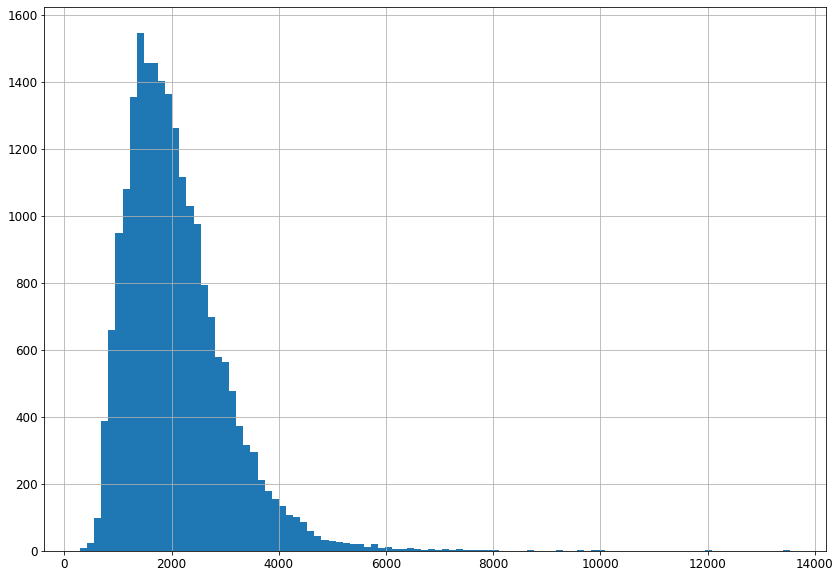

In [7]:
housing.sqft_living.hist(bins=100, figsize=(14,10))
plt.show()

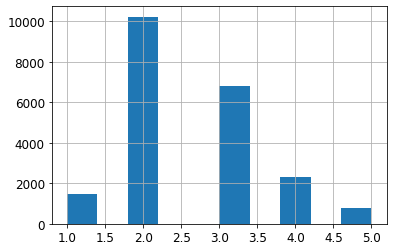

In [8]:
housing["sqft_living_cat"] = pd.cut(housing.sqft_living, 
                                    bins=[0., 1000., 2000., 3000., 4000., np.inf],
                                    labels=[1, 2, 3, 4, 5]
                                   )
housing['sqft_living_cat'].hist()
plt.show()

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing.sqft_living_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
strat_train_set.shape, strat_test_set.shape

((17290, 22), (4323, 22))

In [11]:
strat_train_set.sqft_living_cat.value_counts() / len(strat_train_set)

2   0.473
3   0.316
4   0.106
1   0.069
5   0.036
Name: sqft_living_cat, dtype: float64

In [12]:
strat_test_set.sqft_living_cat.value_counts() / len(strat_test_set)

2   0.473
3   0.316
4   0.106
1   0.069
5   0.036
Name: sqft_living_cat, dtype: float64

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("sqft_living_cat", axis=1, inplace=True)

## 3. Discover and Visualize the Data to Gain Insights

### 3.1 Outlier Detection (optional)

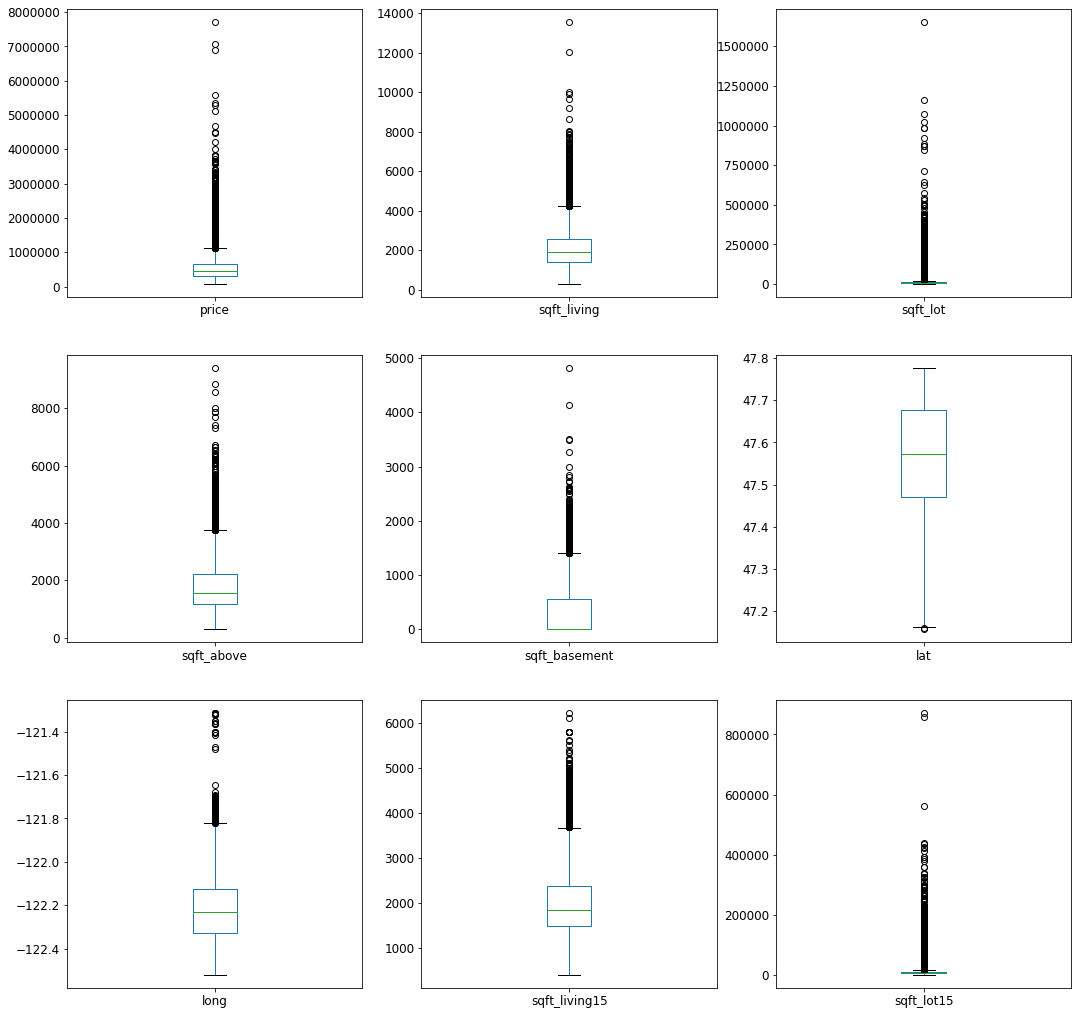

In [14]:
p = housing[
    ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
     'lat', 'long', 'sqft_living15', 'sqft_lot15']
].plot.box(subplots=True, layout=(3, 3), figsize=(18,18))

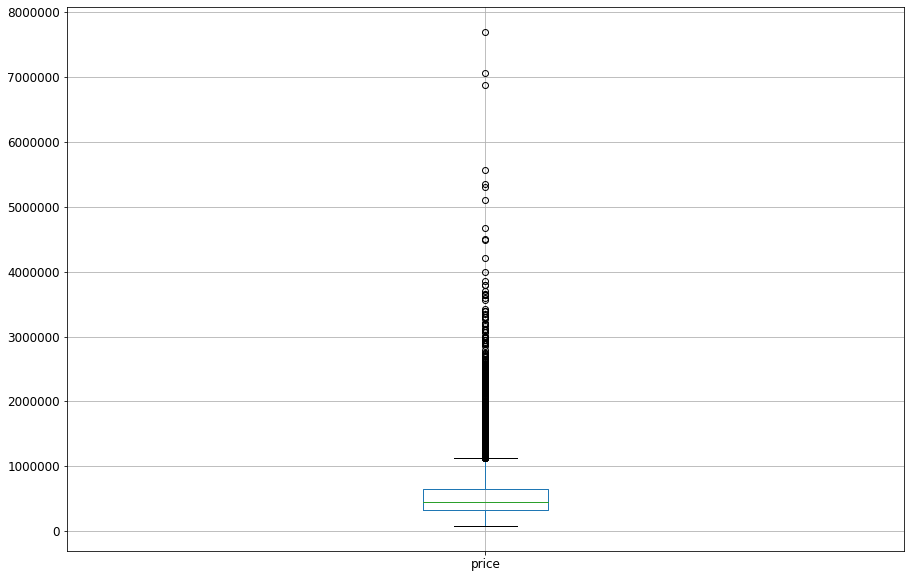

In [15]:
housing[['price']].boxplot(figsize=(15,10))

Box plot use the IQR method to display data and outliers(shape of the data) but in order to be get a list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.

Wikipedia Definition:
_The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, $IQR = Q_3 − Q_1$.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers._

If a data point is below $Q_1 - 1.5\times IQR$ or above $Q_3 + 1.5\times IQR$ then it's an outlier.

<b>Exercise 1:</b> Compute for me the count of outliers in our training set with respect to the `price` feature. (Hint: check the `DataFrame.quantile()` method and find a way to count the occurrences of values in a column of a DataFrame.) Additionally, write the code to remove those outliers. 

In [16]:
## Write you solution here. Add as many cells as you like
q1 = housing.quantile(0.25)
q3 = housing.quantile(0.75)
iqr = q3 - q1
iqr

id              5185851251.000
price               323050.000
bedrooms                 1.000
bathrooms                0.750
sqft_living           1123.000
sqft_lot              5648.000
floors                   1.000
waterfront               0.000
view                     0.000
condition                1.000
grade                    1.000
sqft_above            1020.000
sqft_basement          560.000
yr_built                46.000
yr_renovated             0.000
lat                      0.207
long                     0.203
sqft_living15          870.000
sqft_lot15            4983.000
dtype: float64

In [17]:
outlier_crit_q1_price = housing.price < (q1.price - 1.5 * iqr.price)
outlier_crit_q3_price = housing.price > (q3.price + 1.5 * iqr.price)
outlier_crit = outlier_crit_q1_price | outlier_crit_q3_price
outlier_crit.value_counts()

False    20467
True      1146
Name: price, dtype: int64

In [18]:
housing[outlier_crit]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_cat
5,7237550310,20140512T000000,1225000.000,4,4.500,5420,101930,1.000,0,0,...,3890,1530,2001,0,98053,47.656,-122.005,4760,101930,5
21,2524049179,20140826T000000,2000000.000,3,2.750,3050,44867,1.000,0,4,...,2330,720,1968,0,98040,47.532,-122.233,4110,20336,4
49,822039084,20150311T000000,1350000.000,3,2.500,2753,65005,1.000,1,2,...,2165,588,1953,0,98070,47.404,-122.451,2680,72513,3
69,1802000060,20140612T000000,1325000.000,5,2.250,3200,20158,1.000,0,0,...,1600,1600,1965,0,98004,47.630,-122.215,3390,20158,4
125,4389200955,20150302T000000,1450000.000,4,2.750,2750,17789,1.500,0,0,...,1980,770,1914,1992,98004,47.614,-122.212,3060,11275,3
153,7855801670,20150401T000000,2250000.000,4,3.250,5180,19850,2.000,0,3,...,3540,1640,2006,0,98006,47.562,-122.162,3160,9750,5
216,46100204,20150221T000000,1505000.000,5,3.000,3300,33474,1.000,0,3,...,1870,1430,1957,1991,98040,47.567,-122.210,3836,20953,4
246,2025069065,20140929T000000,2400000.000,4,2.500,3650,8354,1.000,1,4,...,1830,1820,2000,0,98074,47.634,-122.072,3120,18841,4
269,7960900060,20150504T000000,2900000.000,4,3.250,5050,20100,1.500,0,2,...,4750,300,1982,2008,98004,47.631,-122.223,3890,20060,5
270,4054500390,20141007T000000,1365000.000,4,4.750,5310,57346,2.000,0,0,...,5310,0,1989,0,98077,47.728,-122.042,4180,47443,5


Are the outliers legitimate or should we remove them?

### 3.2 Visualize geographical data

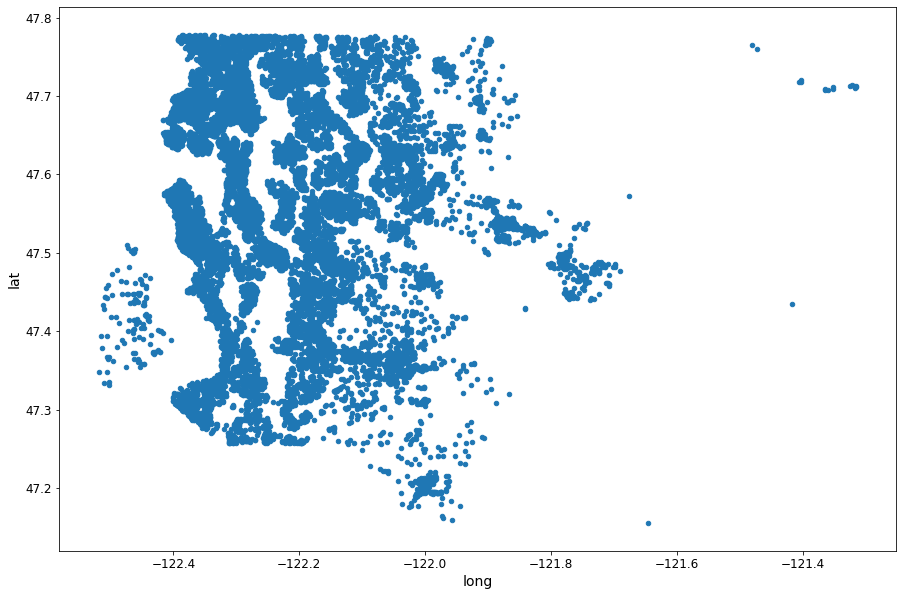

In [19]:
housing.plot(kind="scatter", x="long", y="lat", figsize=(15,10))
plt.show()

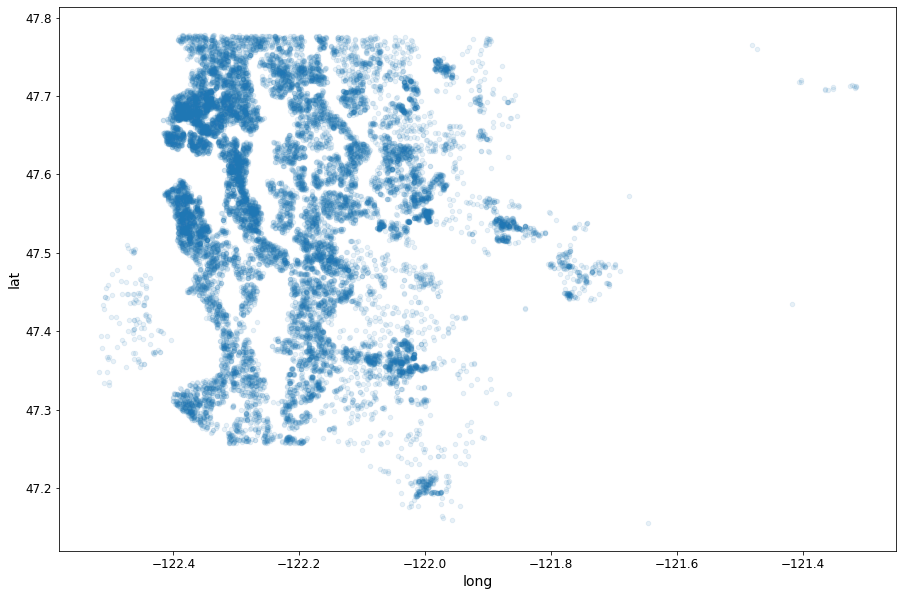

In [20]:
housing.plot(kind="scatter", x="long", y="lat", alpha=0.1, figsize=(15,10))
plt.show()

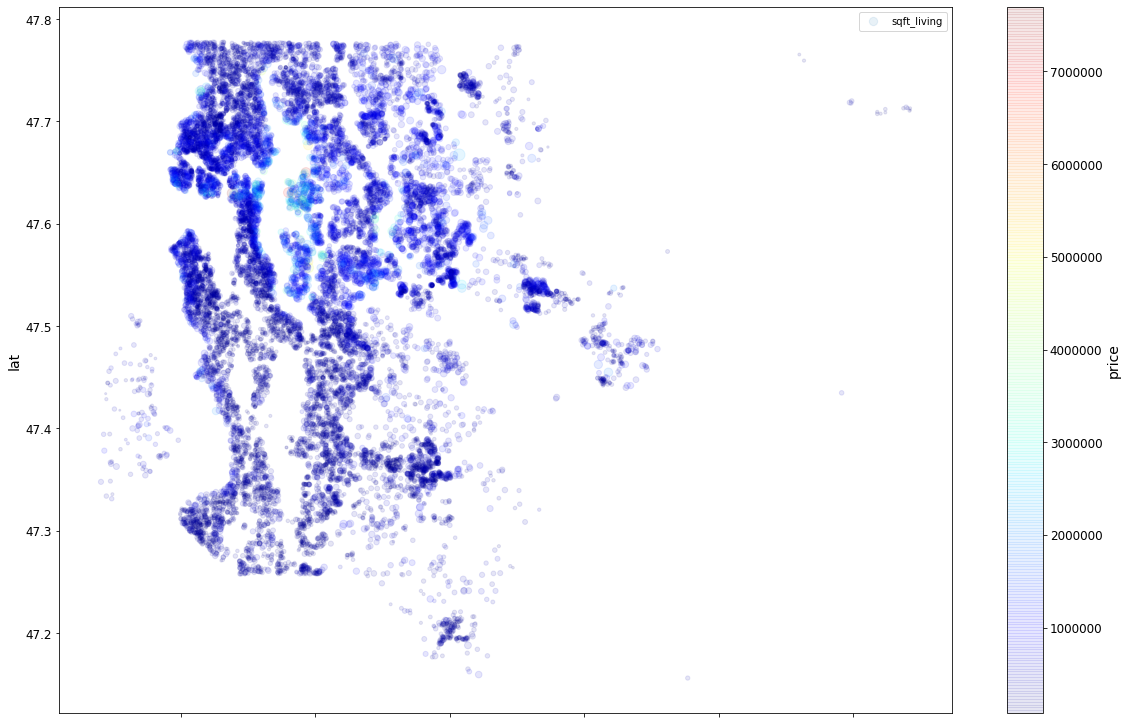

In [21]:
housing.plot(
    kind="scatter", x="long", y="lat", alpha=0.1, figsize=(20,13),
    s=housing["sqft_living"]/100, label="sqft_living",
    c="price", cmap=plt.get_cmap('jet'), colorbar=True
)
plt.legend()
plt.show()

<b>Exercise 2:</b> Using the same colormap (i.e. jet), try to improve the visualization above, setting an upper value that is reasonable, (i.e less or equal to QR3 + 1.5 IQR such as 1,000,000 $), and not the highest value in the range.

Hint: I suggest you to create a custom discrete colorbar by using `matplotlib.colors.BoundaryNorm` as normalizer for your scatterplot. See the norm argument in `matplotlib.pyplot.scatter()`: https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.scatter.html

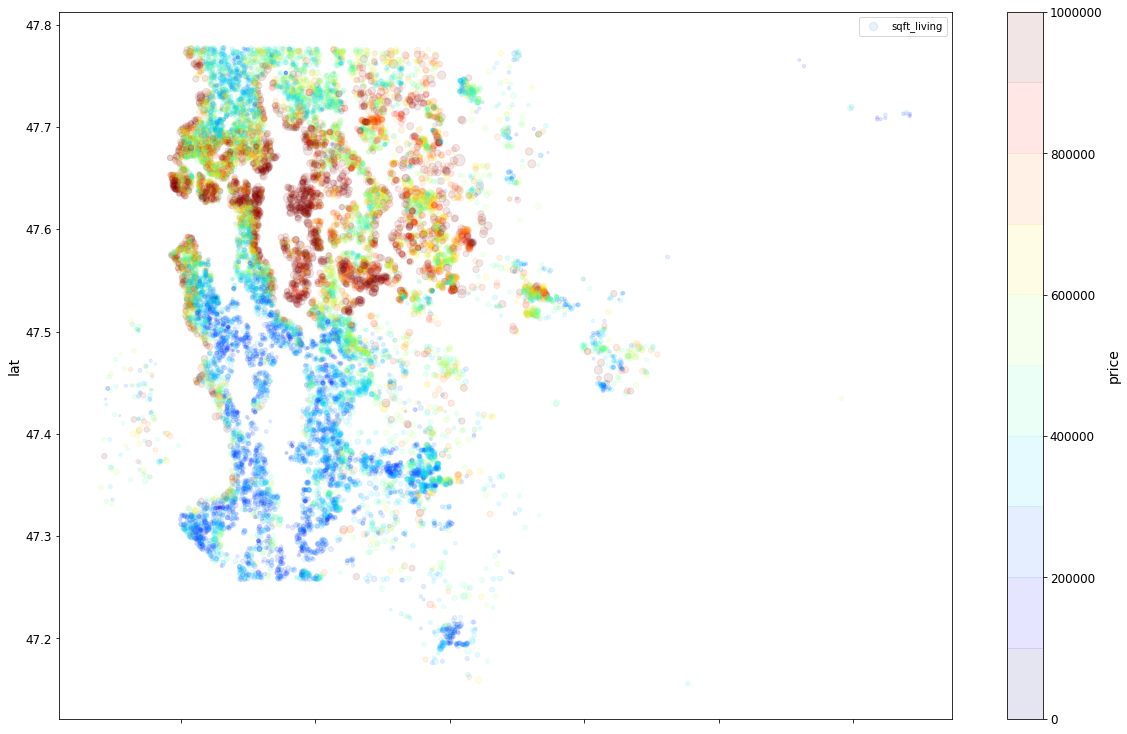

In [22]:
## Write your solution here
cmap = plt.cm.jet  # define the colormap
bounds = np.linspace(0, 1e6, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
housing.plot(
    kind="scatter", x="long", y="lat", alpha=0.1, figsize=(20,13),
    s=housing["sqft_living"]/100, label="sqft_living",
    c="price", cmap=cmap, norm=norm, colorbar=True
)
plt.show()

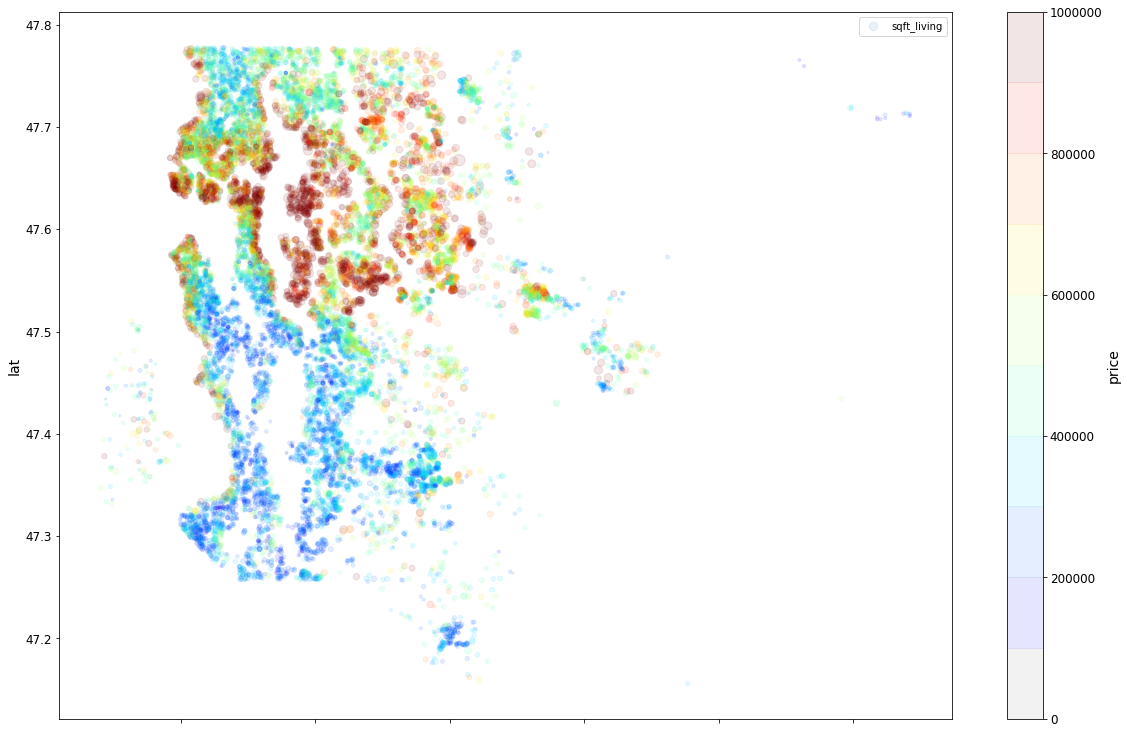

In [23]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 1e6, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
housing.plot(
    kind="scatter", x="long", y="lat", alpha=0.1, figsize=(20,13),
    s=housing["sqft_living"]/100, label="sqft_living",
    c="price", cmap=cmap, norm=norm, colorbar=True
)
plt.show()

### 3.2 Looking for correlations

The dataset is not that big, and we can compute the standard correlation coefficient (Pearson’s r coefficient) between every two features using the `DataFrame.corr()` method:

In [24]:
corr_matrix = housing.corr()
corr_matrix["price"].sort_values(ascending=False)

price            1.000
sqft_living      0.702
grade            0.667
sqft_above       0.606
sqft_living15    0.585
bathrooms        0.525
view             0.397
sqft_basement    0.324
bedrooms         0.308
lat              0.307
waterfront       0.266
floors           0.257
yr_renovated     0.126
sqft_lot         0.090
sqft_lot15       0.082
yr_built         0.054
condition        0.036
long             0.022
id              -0.017
Name: price, dtype: float64

N.B. The correlation coefficient only measures linear correlations, and it may completely miss nonlinear correlation factors. 

Another way to check for correlation visually is to use the `scatter_matrix()` utility function offered by Pandas, which leverages `matplotlib`, or seaborn's `pairplot()` function.

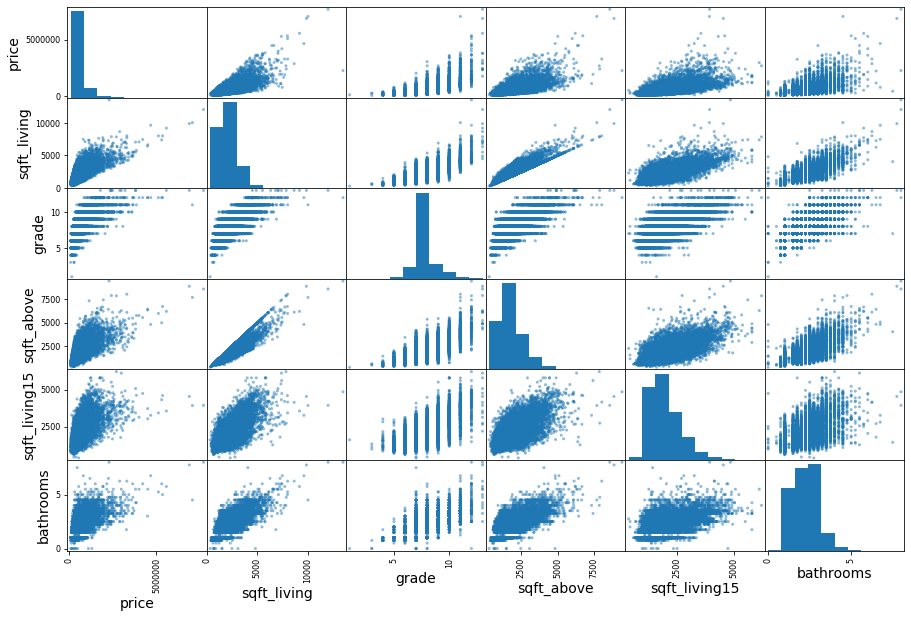

In [25]:
attributes = ["price", "sqft_living", "grade",
              "sqft_above", "sqft_living15", "bathrooms"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(15, 10))
plt.show()

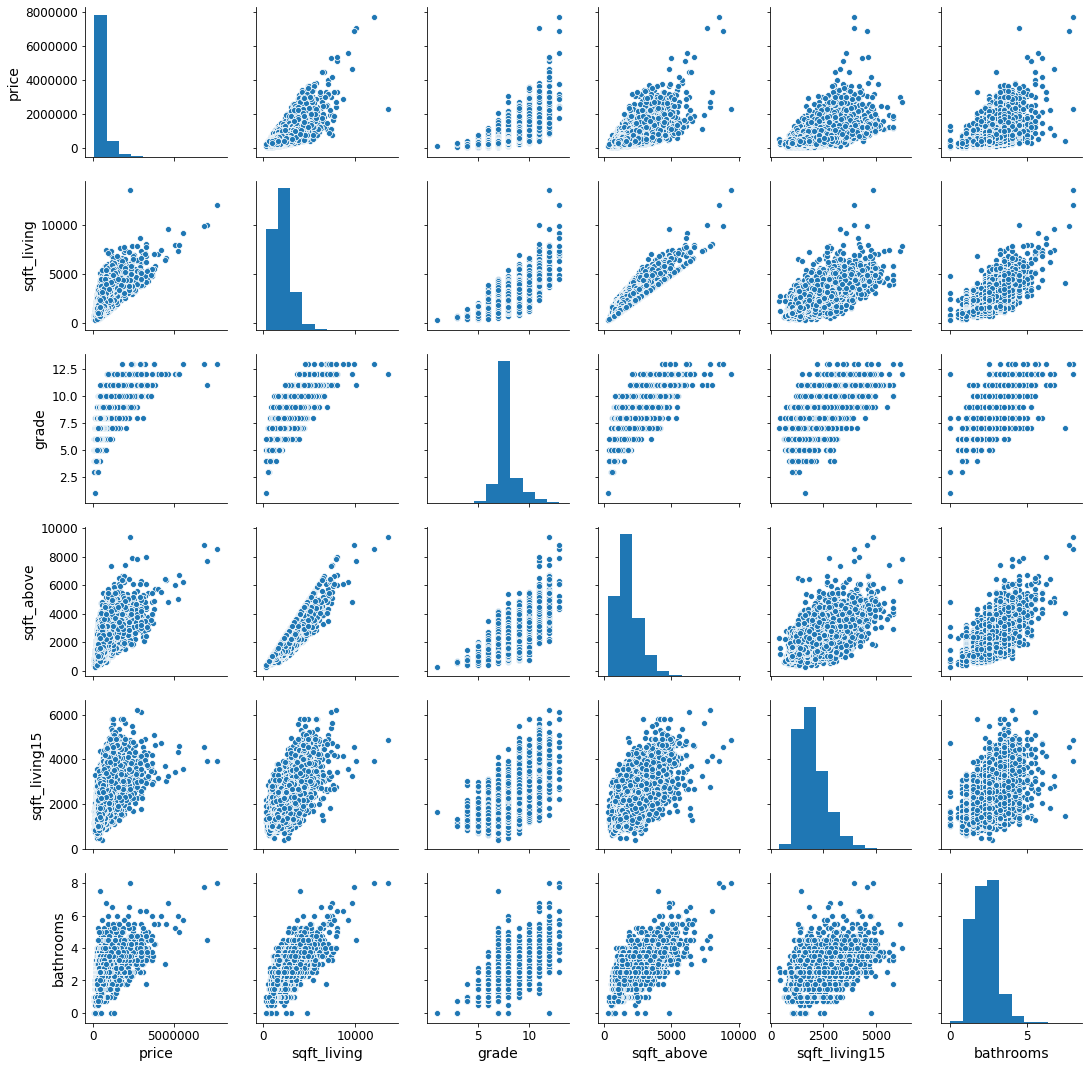

In [26]:
import seaborn as sns
ax = sns.pairplot(housing[attributes])

We can then start using boxplots or violinplots to further investigate targeted correlations, such as 'grade' vs 'price' or 'floors' vs 'price'.

<b>Exercise 3:</b> write a function that takes a categorical or ordinal feature as a first argument, the size of a figure as a second argument and plots, using seaborn, a set of boxplots of the price distribution for each category in the input categorical feature.

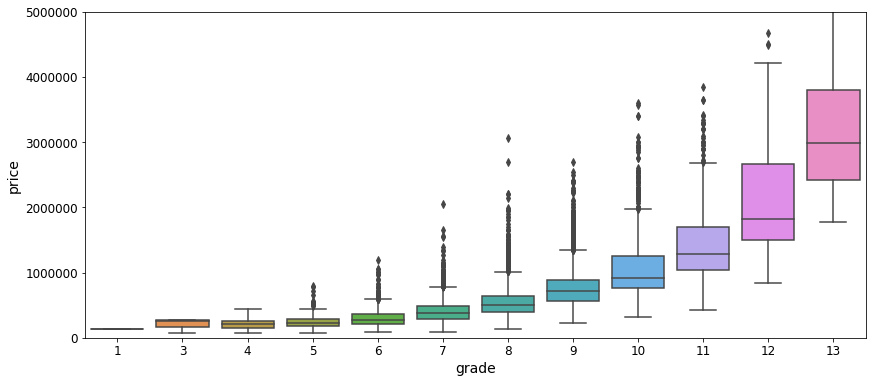

In [27]:
## Write you solution here.
# Populate the function body. I've written the function interfaxe (i.e. its API) for you
def print_boxplot(feature, figsize=(14, 6)):
    """
    write your function here
    """
    data = pd.concat([housing['price'], housing[feature]], axis=1)
    f, ax = plt.subplots(figsize=figsize)
    fig = sns.boxplot(x=feature, y="price", data=data)
    fig.axis(ymin=0, ymax=5000000);
## Try your function to plot 'grade' vs 'price'.
print_boxplot('grade')

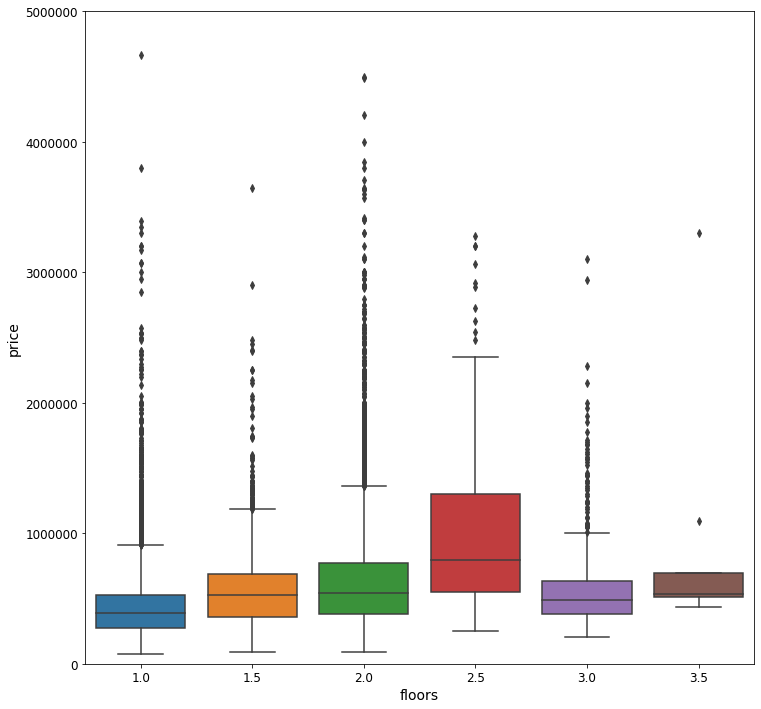

In [28]:
## Try your function to plot 'floors' vs 'price'.
print_boxplot('floors', figsize=(12, 12))

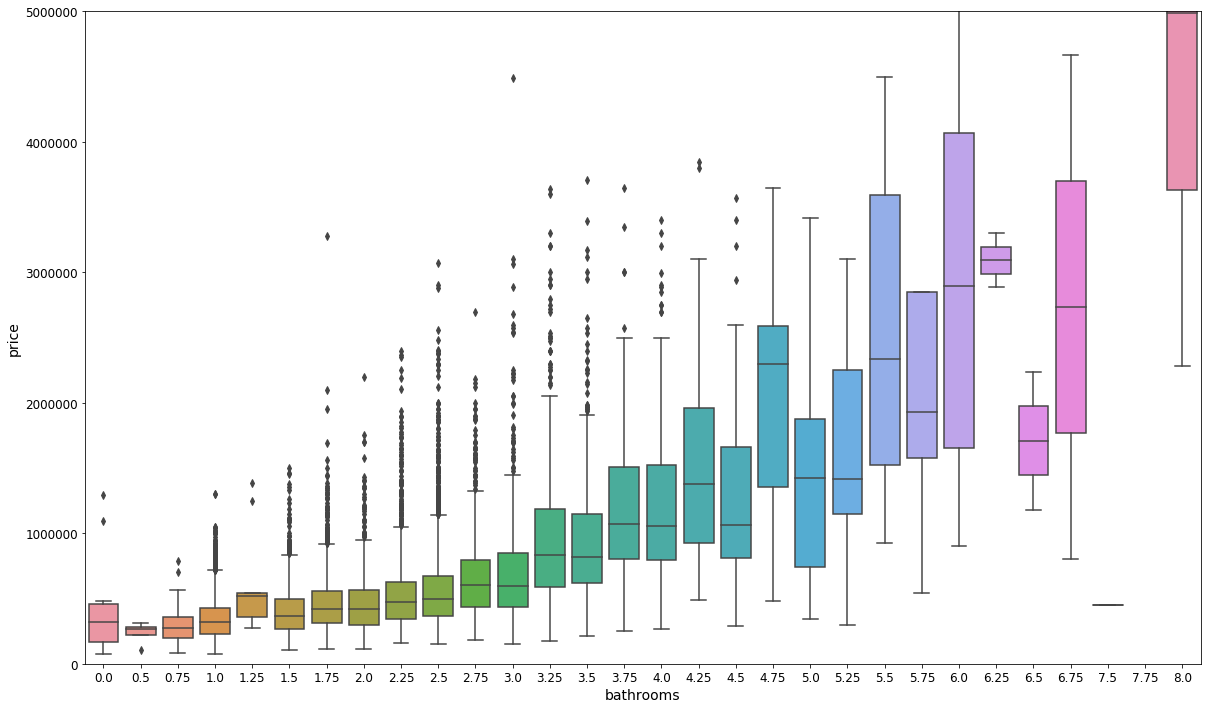

In [29]:
## Try your function to plot 'bathrooms' vs 'price'.
print_boxplot('bathrooms', figsize=(20, 12))

## 4. Preparing the Data for Machine Learning Algorithms

### 4.1 Data Cleaning

In [30]:
housing = strat_train_set.drop("price", axis=1) # drop labels for training set
housing_labels = strat_train_set["price"].copy()

In [31]:
## Look for rows with incomplete values
incomplete_rows = housing[housing.isnull().any(axis=1)]
incomplete_rows

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


As there is no missing value we do not need to do this. We can ignore it

In [32]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num.values)
imputer.statistics_

array([ 3.90e+09,  3.00e+00,  2.25e+00,  1.91e+03,  7.61e+03,  1.50e+00,
        0.00e+00,  0.00e+00,  3.00e+00,  7.00e+00,  1.56e+03,  0.00e+00,
        1.98e+03,  0.00e+00,  4.76e+01, -1.22e+02,  1.84e+03,  7.62e+03])

In [33]:
housing_num.median().values

array([ 3.90e+09,  3.00e+00,  2.25e+00,  1.91e+03,  7.61e+03,  1.50e+00,
        0.00e+00,  0.00e+00,  3.00e+00,  7.00e+00,  1.56e+03,  0.00e+00,
        1.98e+03,  0.00e+00,  4.76e+01, -1.22e+02,  1.84e+03,  7.62e+03])

In [34]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr.sort_values(by='bathrooms', ascending=True)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
14423,9543000205.000,0.000,0.000,844.000,4269.000,1.000,0.000,0.000,4.000,7.000,844.000,0.000,1913.000,0.000,47.278,-122.250,1380.000,9600.000
1149,3421079032.000,1.000,0.000,670.000,43377.000,1.000,0.000,0.000,3.000,3.000,670.000,0.000,1966.000,0.000,47.264,-121.906,1160.000,42882.000
6994,2954400190.000,0.000,0.000,4810.000,28008.000,2.000,0.000,0.000,3.000,12.000,4810.000,0.000,1990.000,0.000,47.664,-122.069,4740.000,35061.000
9854,7849202190.000,0.000,0.000,1470.000,4800.000,2.000,0.000,0.000,3.000,7.000,1470.000,0.000,1996.000,0.000,47.526,-121.828,1060.000,7200.000
3119,3918400017.000,0.000,0.000,1470.000,979.000,3.000,0.000,2.000,3.000,8.000,1470.000,0.000,2006.000,0.000,47.715,-122.356,1470.000,1399.000
9773,3374500520.000,0.000,0.000,2460.000,8049.000,2.000,0.000,0.000,3.000,8.000,2460.000,0.000,1990.000,0.000,47.410,-122.168,2520.000,8050.000
875,6306400140.000,0.000,0.000,3064.000,4764.000,3.500,0.000,2.000,3.000,7.000,3064.000,0.000,1990.000,0.000,47.636,-122.322,2360.000,4000.000
10424,7129800036.000,2.000,0.500,580.000,6900.000,1.000,0.000,0.000,3.000,5.000,580.000,0.000,1941.000,0.000,47.514,-122.262,1570.000,5040.000
2261,3971701455.000,2.000,0.500,1180.000,7750.000,1.000,0.000,0.000,4.000,6.000,590.000,590.000,1945.000,0.000,47.769,-122.316,1380.000,8976.000
12041,2991000160.000,4.000,0.500,2300.000,5570.000,2.000,0.000,0.000,3.000,8.000,2300.000,0.000,1996.000,0.000,47.328,-122.168,1820.000,6371.000


In [35]:
housing_tr.loc[[14423, 1149, 6994]]

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
14423,9543000205.000,0.000,0.000,844.000,4269.000,1.000,0.000,0.000,4.000,7.000,844.000,0.000,1913.000,0.000,47.278,-122.250,1380.000,9600.000
1149,3421079032.000,1.000,0.000,670.000,43377.000,1.000,0.000,0.000,3.000,3.000,670.000,0.000,1966.000,0.000,47.264,-121.906,1160.000,42882.000
6994,2954400190.000,0.000,0.000,4810.000,28008.000,2.000,0.000,0.000,3.000,12.000,4810.000,0.000,1990.000,0.000,47.664,-122.069,4740.000,35061.000


We might want to look for weird values as well...as it can be seen from the boxplotof bathrooms vs price some houses seem to have no bathroom. This is most likely an error and we may wont to replace those values with the median values for for bathrooms as well.

In [36]:
housing_tr.loc[housing['bathrooms'] == 0, 'bathrooms'] = np.nan
housing_tr.bathrooms.isnull().value_counts()

False    17283
True         7
Name: bathrooms, dtype: int64

In [37]:
housing_tr.bathrooms.fillna(housing_tr.bathrooms.median(), inplace=True)

In [38]:
housing_tr.loc[[14423, 1149, 6994]]

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
14423,9543000205.000,0.000,2.250,844.000,4269.000,1.000,0.000,0.000,4.000,7.000,844.000,0.000,1913.000,0.000,47.278,-122.250,1380.000,9600.000
1149,3421079032.000,1.000,2.250,670.000,43377.000,1.000,0.000,0.000,3.000,3.000,670.000,0.000,1966.000,0.000,47.264,-121.906,1160.000,42882.000
6994,2954400190.000,0.000,2.250,4810.000,28008.000,2.000,0.000,0.000,3.000,12.000,4810.000,0.000,1990.000,0.000,47.664,-122.069,4740.000,35061.000


### 4.2 Transform Rows

It is always a good practice to write functions (or classes) to perform data transformations, so that these operations can later be performed in a reliable and reproducible way.

Below, we have a method that replaces zeroes with the median values for bathrooms, and splits the date the house was sold into `month_bought` and `yr_bought`, then computes the `age` (in years) of teh house when it was sold and introduces a boolean flag (`renovated_flag`) that states whether the house was renovated or not before being sold. It then removes features deemed not relevant (such as `id`, `date`, `yr_built`, `yr_bought`, `month_bought`, `yr_renovated`).

In [39]:
housing['date']

20474    20141002T000000
3840     20140612T000000
7426     20141212T000000
4038     20150415T000000
11420    20141024T000000
12116    20140716T000000
14161    20140908T000000
21429    20140625T000000
17076    20150407T000000
1345     20140728T000000
11924    20141006T000000
19899    20150330T000000
2194     20140804T000000
20165    20140718T000000
12056    20140604T000000
11824    20140822T000000
157      20140807T000000
11415    20140509T000000
6551     20140908T000000
9443     20150325T000000
17619    20140804T000000
17108    20150402T000000
12481    20150512T000000
11121    20140716T000000
19682    20150218T000000
15385    20150225T000000
8384     20140624T000000
5968     20141211T000000
5774     20150226T000000
6736     20140925T000000
              ...       
14581    20150408T000000
7654     20141121T000000
11842    20140623T000000
15839    20140725T000000
11745    20140911T000000
12760    20140924T000000
14259    20150407T000000
17596    20150401T000000
2811     20150320T000000


In [40]:
def transform_housing_rows(housing_df):
    """
     housing_df['date_as_ordinal'] = housing.date.apply(
         lambda d: date(int(d[:4]), int(d[4:6]), int(d[6:8])).toordinal()
     )
    """
    res = housing_df.copy()
    res.loc[housing_df['bathrooms'] == 0, 'bathrooms'] = np.nan
    res.bathrooms.fillna(res.bathrooms.median(), inplace=True)
    if 'date' in res.columns.values:
        res['yr_bought'] = res['date'].apply(lambda d: int(d[:4]))
        res['month_bought'] = res['date'].apply(lambda d: int(d[4:6]))
        res['age'] = res['yr_bought'] - housing_df['yr_built']
    res['renovated_flag'] = res['yr_renovated'].apply(lambda el: 0 if el == 0.0  else 1)
    return res.drop(
        columns=['id', 'date', 'yr_built', 'yr_bought', 'month_bought', 'yr_renovated'],
        errors='ignore'
    )
    
housing_proc = transform_housing_rows(housing)
housing_proc.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renovated_flag
20474,3,3.250,1380,1234,3.000,0,0,3,8,1380,0,98103,47.694,-122.342,1370,1282,8,0
3840,2,1.000,820,10450,1.000,0,0,4,7,820,0,98055,47.426,-122.199,1240,11200,49,0
7426,3,3.500,4240,21578,2.000,0,0,3,10,3500,740,98040,47.561,-122.215,3120,16440,20,0
4038,4,1.000,1140,6250,1.500,0,0,3,6,1140,0,98126,47.543,-122.375,1140,1370,57,0
11420,3,2.500,1600,3172,2.000,0,0,3,7,1600,0,98053,47.687,-122.042,1690,3698,12,0


### 4.2 Handling Text and Categorical Attributes

In general we can consider three types of text features: categorical, ordinal, and unstructured.
Unstructured text is more the subject of Natural Language Processing, hence we will not consider its processing/encoding at this stage (and we have no unstructured data). Ordinal data are text categories that imply and intrinsic order such as the set ("BAD", "AVERAGE", "GOOD", "VERY GOOD", "EXCELLENT"). These are generally encodes as integers ("BAD" => 0, "AVERAGE" => 1, "GOOD" => 2, "VERY GOOD" => 3, "EXCELLENT" => 4). These transformations can be handed with custom functions as above.

To handle Categorical Attributes that are not ordinal, a common solution is to create one binary attribute per category. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy attributes*. Scikit-Learn provides a `sklearn.preprocessing.OneHotEncoder` class to convert categorical values into one-hot vectors.

In our case we have the "zipcode" attribute that can be considered as categorical. Each "zipcode" category should become a mutually exclusive dummy attribute

<b>Exercise 4:</b> Use the `OneHotEncoder` class to encode each ZIP code as a separate category. Check the documentation for appropriate use of the `OneHotEncoder` transformer. What kind of output do you get? 

In [41]:
## Write your solution here
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(categories='auto')
housing_zipcode = housing[["zipcode"]]
print(housing_zipcode)
housing_zipcode_1hot = cat_encoder.fit_transform(housing_zipcode)
housing_zipcode_1hot

      zipcode
20474   98103
3840    98055
7426    98040
4038    98126
11420   98053
12116   98092
14161   98144
21429   98133
17076   98122
1345    98109
11924   98102
19899   98103
2194    98058
20165   98177
12056   98144
11824   98092
157     98023
11415   98077
6551    98075
9443    98116
17619   98072
17108   98155
12481   98178
11121   98117
19682   98166
15385   98034
8384    98103
5968    98074
5774    98072
6736    98027
...       ...
14581   98198
7654    98052
11842   98198
15839   98144
11745   98038
12760   98126
14259   98058
17596   98024
2811    98053
1224    98118
16915   98002
21405   98059
7326    98155
3237    98056
13924   98033
11330   98126
13160   98027
609     98028
7697    98077
18260   98115
12019   98115
14242   98125
5294    98117
12733   98033
18243   98103
14469   98117
8505    98052
549     98168
4482    98117
1941    98006

[17290 rows x 1 columns]


<17290x70 sparse matrix of type '<class 'numpy.float64'>'
	with 17290 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. 

In [42]:
housing_zipcode_1hot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
cat_encoder.categories_

[array(['98001', '98002', '98003', '98004', '98005', '98006', '98007',
        '98008', '98010', '98011', '98014', '98019', '98022', '98023',
        '98024', '98027', '98028', '98029', '98030', '98031', '98032',
        '98033', '98034', '98038', '98039', '98040', '98042', '98045',
        '98052', '98053', '98055', '98056', '98058', '98059', '98065',
        '98070', '98072', '98074', '98075', '98077', '98092', '98102',
        '98103', '98105', '98106', '98107', '98108', '98109', '98112',
        '98115', '98116', '98117', '98118', '98119', '98122', '98125',
        '98126', '98133', '98136', '98144', '98146', '98148', '98155',
        '98166', '98168', '98177', '98178', '98188', '98198', '98199'],
       dtype=object)]

### 4.3 Custom Transformers (see if we should do this one)

You can define you own transformers creating a class that inherits both from `BaseEstimator` (so that it inherits the `.fit()` method) and the mixin class `TransformerMixin` (so that it acquires the `.tranform()` method)

Here below you can see a transformer that set two new features: `renovated_flag` and `age`.

Transformers can take DataFrames as inputs but always output NumPy arrays, so for some transformations where you find more convenient to work on DataFrame you might prefer just to write you own functions that return a modified DataFrame as we did with `transform_housing_rows()`

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

yr_built_ix = housing.columns.values.tolist().index('yr_built') 
yr_renovated_ix = housing.columns.values.tolist().index('yr_renovated')
print(yr_built_ix, yr_renovated_ix)

class ManipulatedAttributesAdder(BaseEstimator, TransformerMixin):
    
    CURRENT_YEAR = 2017
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        age = self.CURRENT_YEAR - X[:, yr_built_ix]
        renovated_flag = np.apply_along_axis(lambda r: 0 if r[yr_renovated_ix] == 0 else 1, 1, X)
        return np.concatenate((X, age[:, np.newaxis], renovated_flag[:, np.newaxis]), axis=1)

attr_adder = ManipulatedAttributesAdder()
housing_extra_attribs = pd.DataFrame(
    attr_adder.transform(housing_num.values),
    columns=[*housing_num.columns.values.tolist(), 'age', 'is_renovated'],
    index=housing_num.index
)
housing_extra_attribs.head(10)

13 14


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,age,is_renovated
20474,993000315.000,3.000,3.250,1380.000,1234.000,3.000,0.000,0.000,3.000,8.000,1380.000,0.000,2006.000,0.000,47.694,-122.342,1370.000,1282.000,2017.000,1.000
3840,522059013.000,2.000,1.000,820.000,10450.000,1.000,0.000,0.000,4.000,7.000,820.000,0.000,1965.000,0.000,47.426,-122.199,1240.000,11200.000,2017.000,1.000
7426,2524000050.000,3.000,3.500,4240.000,21578.000,2.000,0.000,0.000,3.000,10.000,3500.000,740.000,1994.000,0.000,47.561,-122.215,3120.000,16440.000,2017.000,1.000
4038,3277801450.000,4.000,1.000,1140.000,6250.000,1.500,0.000,0.000,3.000,6.000,1140.000,0.000,1958.000,0.000,47.543,-122.375,1140.000,1370.000,2017.000,1.000
11420,7202290320.000,3.000,2.500,1600.000,3172.000,2.000,0.000,0.000,3.000,7.000,1600.000,0.000,2002.000,0.000,47.687,-122.042,1690.000,3698.000,2017.000,1.000
12116,520069032.000,3.000,1.750,1890.000,93218.000,1.000,0.000,0.000,4.000,7.000,1890.000,0.000,1964.000,0.000,47.257,-122.070,1690.000,172062.000,2017.000,1.000
14161,7660100085.000,5.000,2.750,2860.000,6000.000,2.500,0.000,0.000,4.000,8.000,2380.000,480.000,1902.000,0.000,47.591,-122.316,2240.000,6000.000,2017.000,1.000
21429,1139000062.000,3.000,2.500,1150.000,887.000,3.000,0.000,0.000,3.000,7.000,1150.000,0.000,2007.000,0.000,47.707,-122.356,1180.000,915.000,2017.000,1.000
17076,5351200280.000,4.000,2.500,2390.000,5071.000,2.000,0.000,0.000,3.000,9.000,1760.000,630.000,1988.000,0.000,47.614,-122.283,1940.000,5071.000,2017.000,1.000
1345,9301300751.000,3.000,1.500,1200.000,890.000,2.000,0.000,0.000,3.000,8.000,1030.000,170.000,2008.000,0.000,47.638,-122.342,1230.000,2120.000,2017.000,1.000


An alternative way to perform this transformation:

### 4.4 Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. In the great majority of case, Machine Learning algorithms will not perform well when the input numerical attributes have very different scales.

There are two common ways to get all attributes to have the same scale: min-max scaling (using scikit-learn `MinMaxScaler`) and standardization (using scikit-learn `StandardScaler`).

### 4.5 Transformation Pipelines

We are goin to use a `StandardScaler` directly after our `ManipulatedAttributesAdder` class using a Tranformation Pipeline

In [45]:
housing_num.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000,17290.000
mean,4592511252.589,3.373,2.115,2079.757,14960.547,1.493,0.008,0.233,3.409,7.658,1787.130,292.627,1971.044,85.507,47.560,-122.214,1983.980,12647.374
std,2878747193.514,0.937,0.768,912.844,41658.782,0.539,0.088,0.763,0.650,1.180,824.641,442.167,29.390,404.116,0.138,0.141,684.765,26603.536
min,1000102.000,0.000,0.000,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,0.000,1900.000,0.000,47.156,-122.519,399.000,651.000
25%,2124054210.000,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,1951.000,0.000,47.470,-122.329,1480.000,5100.000
50%,3904990345.000,3.000,2.250,1910.000,7610.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,47.571,-122.231,1840.000,7620.000
75%,7312400078.750,4.000,2.500,2550.000,10697.750,2.000,0.000,0.000,4.000,8.000,2210.000,570.000,1997.000,0.000,47.678,-122.125,2360.000,10118.000
max,9900000190.000,33.000,7.750,9890.000,1651359.000,3.500,1.000,4.000,5.000,13.000,8860.000,4820.000,2015.000,2015.000,47.778,-121.315,6210.000,858132.000


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

housing_num_tr = transform_housing_rows(housing_num)
housing_num_prepared = num_pipeline.fit_transform(housing_num_tr)
housing_num_prepared.shape

(17290, 16)

In [47]:
housing_num_prepared.min(axis=1), housing_num_prepared.max(axis=1)

(array([-0.91, -1.47, -0.63, ..., -1.47, -1.46, -0.66]),
 array([2.79, 0.91, 2.37, ..., 0.91, 0.93, 2.32]))

Until now, we have handled the categorical columns and the numerical columns separately. It would be more convenient if we had just one transformer capable to handle all columns, applying the appropriate transformations to each column. Solution: we can use scikit-learn `ColumnTransformer`!

<b>Exercise 5:</b> Use the `sklearn.compose.ColumnTransformer` class to create a pipeline that processes separately the Numerical Attributes (using the `num_pipeline` that we have defined above) and the Categorical Atrribute `zipcode` using a one-hot-encoding without scaling. The binary attributes should remain unmodified

In [48]:
## Write your solution here:
from sklearn.compose import ColumnTransformer

housing_tr = transform_housing_rows(housing)

cat_attribs = ['zipcode']
binary_attribs = ['renovated_flag', 'waterfront', 'view']

num_attribs = [el for el in list(
housing_tr.select_dtypes(include=[np.number])) if el not in binary_attribs]

In [49]:
num_attribs

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'age']

In [50]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(categories='auto'), cat_attribs)
], remainder='passthrough')

housing_prepared = full_pipeline.fit_transform(housing_tr)

`OneHotEncoder` returns a sparse matrix, while `num_pipeline` returns a dense matrix. `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold. In this example, it returns a sparse matrix. 

And now we are done! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

In [51]:
housing_prepared

<17290x87 sparse matrix of type '<class 'numpy.float64'>'
	with 261922 stored elements in Compressed Sparse Row format>

In [52]:
type(housing_prepared)

scipy.sparse.csr.csr_matrix

## Save all the pre-processed data (if needed, skipped in the class demo)

We will use `scipy.sparse.save_npz()` to save the sparse matrix, `np.save()` to save the NumPy arrays as `.npy` binary files, and `pickle` from the Python standard library to save our `full_pipeline`

In [53]:
"""
import pickle
from scipy.sparse import save_npz

X_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_house_data_prepared.npz'))
y_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_prediction.npy'))
train_set_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_train_set.csv'))
test_set_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_test_set.csv'))
pipeline_filepath = os.path.abspath(os.path.join('..', 'dumps', 'full_preprocessing_pipeline'))

# create the "dumps" directory if it does not exist
os.makedirs(os.path.abspath(os.path.join('..', 'dumps')), exist_ok=True)

with open(pipeline_filepath, 'wb') as file_handle:
    pickle.dump(full_pipeline, file_handle)
    
print(type(strat_train_set), type(strat_test_set))

save_npz(X_filepath, housing_prepared)
np.save(y_filepath, housing_labels)
strat_train_set.to_csv(train_set_filepath)
strat_test_set.to_csv(test_set_filepath)
# np.save(train_set_filepath, strat_train_set)
# np.save(test_set_filepath, strat_test_set)
"""

'\nimport pickle\nfrom scipy.sparse import save_npz\n\nX_filepath = os.path.abspath(os.path.join(\'..\', \'dumps\', \'kc_house_data_prepared.npz\'))\ny_filepath = os.path.abspath(os.path.join(\'..\', \'dumps\', \'kc_housed_data_prediction.npy\'))\ntrain_set_filepath = os.path.abspath(os.path.join(\'..\', \'dumps\', \'kc_housed_data_train_set.csv\'))\ntest_set_filepath = os.path.abspath(os.path.join(\'..\', \'dumps\', \'kc_housed_data_test_set.csv\'))\npipeline_filepath = os.path.abspath(os.path.join(\'..\', \'dumps\', \'full_preprocessing_pipeline\'))\n\n# create the "dumps" directory if it does not exist\nos.makedirs(os.path.abspath(os.path.join(\'..\', \'dumps\')), exist_ok=True)\n\nwith open(pipeline_filepath, \'wb\') as file_handle:\n    pickle.dump(full_pipeline, file_handle)\n    \nprint(type(strat_train_set), type(strat_test_set))\n\nsave_npz(X_filepath, housing_prepared)\nnp.save(y_filepath, housing_labels)\nstrat_train_set.to_csv(train_set_filepath)\nstrat_test_set.to_csv(test

In [54]:
"""
some_data = strat_train_set.iloc[:10]
some_labels = strat_test_set.iloc[:10]
preprocessed_some_data = full_pipeline.transform(some_data)
"""

'\nsome_data = strat_train_set.iloc[:10]\nsome_labels = strat_test_set.iloc[:10]\npreprocessed_some_data = full_pipeline.transform(some_data)\n'

## 5. Select and train a model - Regression (Ch4 p 112)

We will start by looking at the Linear Regression model, the simplest Regression model there is. There are two different ways to train it:

* Using a direct “closed-form” equation that directly computes the model parameters that best fit the model to the training set (i.e., the model parameters that minimize the cost function over the training set).

* Using an iterative optimization approach called Gradient Descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent: Batch GD, Mini-batch GD, and Stochastic GD. This will be used again later on, when we will be seeing Neural Networks

In [55]:
# For now we will only use the numerical fields and discard the categorical field "zipcode"
housing_num

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
20474,993000315,3,3.250,1380,1234,3.000,0,0,3,8,1380,0,2006,0,47.694,-122.342,1370,1282
3840,522059013,2,1.000,820,10450,1.000,0,0,4,7,820,0,1965,0,47.426,-122.199,1240,11200
7426,2524000050,3,3.500,4240,21578,2.000,0,0,3,10,3500,740,1994,0,47.561,-122.215,3120,16440
4038,3277801450,4,1.000,1140,6250,1.500,0,0,3,6,1140,0,1958,0,47.543,-122.375,1140,1370
11420,7202290320,3,2.500,1600,3172,2.000,0,0,3,7,1600,0,2002,0,47.687,-122.042,1690,3698
12116,520069032,3,1.750,1890,93218,1.000,0,0,4,7,1890,0,1964,0,47.257,-122.070,1690,172062
14161,7660100085,5,2.750,2860,6000,2.500,0,0,4,8,2380,480,1902,0,47.591,-122.316,2240,6000
21429,1139000062,3,2.500,1150,887,3.000,0,0,3,7,1150,0,2007,0,47.707,-122.356,1180,915
17076,5351200280,4,2.500,2390,5071,2.000,0,0,3,9,1760,630,1988,0,47.614,-122.283,1940,5071
1345,9301300751,3,1.500,1200,890,2.000,0,0,3,8,1030,170,2008,0,47.638,-122.342,1230,2120


In [56]:
housing_labels

20474    379000.000
3840     173000.000
7426    1393000.000
4038     390000.000
11420    440500.000
12116    267300.000
14161    750000.000
21429    288000.000
17076    845000.000
1345     464950.000
11924   1443920.000
19899    380000.000
2194     265000.000
20165    865000.000
12056    317000.000
11824    205000.000
157      320000.000
11415    590000.000
6551     615000.000
9443     593000.000
17619    451000.000
17108    540000.000
12481    625000.000
11121    375000.000
19682    720000.000
15385    450000.000
8384     510000.000
5968     490000.000
5774     310000.000
6736     725000.000
            ...    
14581     95000.000
7654     640000.000
11842    199950.000
15839    500000.000
11745    299950.000
12760    382000.000
14259    347000.000
17596   1650000.000
2811     963990.000
1224     735000.000
16915    137000.000
21405    460000.000
7326     275000.000
3237     739000.000
13924    870000.000
11330    619500.000
13160    240000.000
609      590000.000
7697     697000.000


In [57]:
housing_num_tr = transform_housing_rows(housing_num)
housing_prepared = num_pipeline.fit_transform(housing_num_tr)
housing_prepared.shape

(17290, 16)

### 5.1 Closed form solution: Normal Equation (Ch4 p114)

We will use the `LinearRegression` class from `scikit-learn`

In [58]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
lin_reg.intercept_, lin_reg.coef_

(539396.9331983756,
 array([-25672.77,   4020.2 ,  85966.67,   8301.72, -13208.28,  47906.95,
         41615.36,  36142.25,  98997.58,  79999.14,  28277.94,  89348.06,
        -34963.97,  19514.55,  -9608.81,  21065.58]))

Let’s try it out on a few instances from the training set:

In [59]:
some_data = housing_num.iloc[:10]
some_labels = housing_labels.iloc[:10]
preprocessed_some_data = num_pipeline.transform(
    transform_housing_rows(some_data)
)
print("Predictions:", lin_reg.predict(preprocessed_some_data))
print("Labels:", list(some_labels))

Predictions: [ 480821.61  196427.76 1128346.26  170287.53  389404.97  207376.84
  709458.15  356002.56  680037.83  416153.07]
Labels: [379000.0, 173000.0, 1393000.0, 390000.0, 440500.0, 267300.0, 750000.0, 288000.0, 845000.0, 464950.0]


It kinda works, although the predictions are not exactly accurate. Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error()` function:

In [60]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

204254.77687566332

This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model

### 5.2 Gradient Descent (Ch4 p118)

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The concept behind Gradient Descent is to modify parameters iteratively to minimize a cost function.

The MSE cost function for a Linear Regression model is a convex function, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly.

#### 5.2.1 Batch Gradient Descent (Ch4 p121)

No example on this.

#### 5.2.2 Stochastic Gradient Descent (Ch4 p 118)

To perform Linear Regression using Stochastic GD with Scikit-Learn, you can use the `SGDRegressor` class. It defaults to optimizing the squared error cost function. 

In [61]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(
    max_iter=1000,   # max numer of epochs 
    tol=1e-3,
    penalty=None,
    eta0=0.01
)
sgd_reg.fit(housing_prepared, housing_labels)
print('SGD Regressor intercept: {}'.format(sgd_reg.intercept_))
print('SGD Regressor coefficient: {}'.format(sgd_reg.coef_))

SGD Regressor intercept: [541744.57]
SGD Regressor coefficient: [-27528.47   7652.75  89087.26   4590.24  -8899.78  40660.54  45702.64
  36558.39 103776.42  83631.59  27945.84  91635.4  -36306.57  22242.99
 -10459.    19605.  ]


In [62]:
housing_predictions = sgd_reg.predict(housing_prepared)
sgd_mse = mean_squared_error(housing_labels, housing_predictions)
sgd_rmse = np.sqrt(lin_mse)
sgd_rmse

204254.77687566332

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns

def plot_learning_curves(model, X, y, max_training_samples=None):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2
    )
    train_errors, val_errors = [], []
    for m in range(1, min(len(X_train), max_training_samples)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(
            mean_squared_error(y_train[:m], y_train_predict)
        )
        val_errors.append(
            mean_squared_error(y_val, y_val_predict)
        )
    fig, ax = plt.subplots(figsize=(16,10))
    sns.lineplot(data=np.sqrt(train_errors), linewidth=2, label="train", ax=ax)
    sns.lineplot(data=np.sqrt(val_errors), linewidth=2, label="val", ax=ax)

<b>Exercise 6:</b> Initialize and train a `SGDRegressor` named `sgd_reg` with initial learning rate of $0.005$, `penalty` set to `None`, training for a maximum of 500 epochs over all the dataset. Then, pass the model and the input data and the output labels to the `plot_learning_curves()` function, setting its `max_training_samples` argument to $5000$. What is it plotting?

C:\Users\Mikele\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mikele\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mikele\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mikele\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Mikele\Anaconda3\lib\site-p

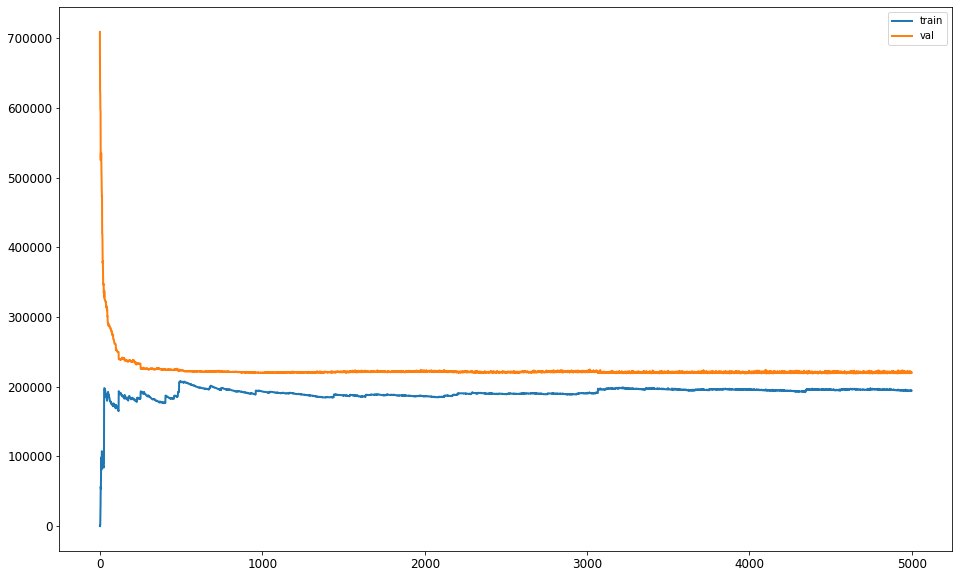

In [64]:
## Write your solution here:
sgd_reg = SGDRegressor(max_iter = 500,
                       penalty=None, 
                       eta0 = 0.005)

plot_learning_curves(sgd_reg, housing_prepared, housing_labels, max_training_samples=5000)

This model is underfitting the training data again. Not surprising!! 

### 5.3 Polynomial Regression (Ch4 p128)

What if your data is more complex than a straight line (or an (N-1)-dimensional plane in an N-dimensional space)? Surprisingly, you can use a linear model to fit nonlinear data. This can be done with Polynomial Regression

In [65]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
housing_poly = poly_features.fit_transform(housing_prepared)

In [66]:
housing_prepared[0]

array([-0.4 ,  1.48, -0.77, -0.33,  2.79, -0.09, -0.31, -0.63,  0.29,
       -0.49, -0.66,  0.96, -0.91, -0.9 , -0.43, -0.21])

In [67]:
housing_poly

array([[-3.99e-01,  1.48e+00, -7.67e-01, ..., -3.86e-02, -1.91e-02,
        -9.47e-03],
       [-1.47e+00, -1.46e+00, -1.38e+00, ..., -6.26e-04, -2.44e-03,
        -9.47e-03],
       [-3.99e-01,  1.81e+00,  2.37e+00, ..., -4.30e-03,  6.38e-03,
        -9.47e-03],
       ...,
       [-1.47e+00, -1.46e+00, -8.32e-01, ..., -1.13e-02, -1.04e-02,
        -9.47e-03],
       [-3.99e-01, -1.46e+00, -1.03e+00, ..., -2.25e-02, -1.46e-02,
        -9.47e-03],
       [-3.99e-01,  1.75e-01,  1.41e+00, ..., -1.38e-03, -3.61e-03,
        -9.47e-03]])

In [68]:
housing_poly[0].shape

(968,)

In [69]:
230/20

11.5

In [70]:
lin_reg = LinearRegression()
lin_reg.fit(housing_poly, housing_labels)
lin_reg.intercept_, lin_reg.coef_

(2479215905854.558,
 array([-3.23e+11,  1.17e+12,  7.39e+11, -2.49e+11, -5.25e+11,  5.80e+13,
         9.53e+12,  8.48e+12,  2.23e+12, -3.95e+11,  8.33e+11,  1.10e+11,
        -2.30e+10,  5.83e+10, -4.06e+10, -2.00e+13, -2.82e+03, -2.81e+03,
        -1.54e+13,  9.96e+03,  1.26e+04, -3.30e+12,  6.06e+03,  1.37e+03,
         3.64e+03,  1.39e+13,  7.47e+12, -1.35e+03, -3.55e+03,  3.74e+03,
         2.25e+03, -1.24e+11, -2.06e+03,  7.91e+12,  3.79e+04, -3.28e+03,
        -6.43e+12, -6.44e+02, -1.85e+03,  3.09e+03, -7.15e+12, -3.83e+12,
         1.71e+01,  7.69e+03, -1.27e+04, -1.01e+03,  7.89e+12,  1.22e+13,
        -2.61e+11, -2.44e+13, -2.61e+12, -1.90e+13, -9.24e+12,  1.61e+11,
         8.29e+12,  1.35e+13, -7.91e+11, -7.61e+11,  6.14e+11,  1.18e+12,
         1.25e+12, -2.95e+03,  6.66e+02, -1.63e+11, -4.00e+03,  1.61e+03,
         5.19e+01,  2.35e+11,  1.26e+11,  2.28e+04,  9.77e+03, -2.32e+04,
         1.13e+04, -1.06e+12, -1.01e+04,  3.66e+10,  9.19e+03,  9.21e+03,
         6.35e+02,

In [71]:
housing_predictions = lin_reg.predict(
    poly_features.transform(housing_prepared)
)
poly_mse = mean_squared_error(
    housing_labels, housing_predictions
)
poly_rmse = np.sqrt(poly_mse)
poly_rmse

127258.74238277478

In [72]:
print('Lower housing price {}'.format(housing_labels.min()))
print('Higher housing price {}'.format(housing_labels.max()))
poly_rmse / (housing_labels.max() - housing_labels.min())

Lower housing price 75000.0
Higher housing price 6885000.0


0.018687039997470598

In [73]:
print('Q1 = {}'.format(housing_labels.quantile(0.25)))
print('Q3 = {}'.format(housing_labels.quantile(0.75)))
poly_rmse / (housing_labels.quantile(0.75) - housing_labels.quantile(0.25))

Q1 = 321500.0
Q3 = 643837.5


0.394799681646643

In [74]:
some_data = housing_num.iloc[:10]
some_labels = housing_labels.iloc[:10]
preprocessed_some_data = num_pipeline.transform(
    transform_housing_rows(some_data)
)
print("Predictions:", lin_reg.predict(
    poly_features.transform(preprocessed_some_data)
))
print("Labels:", list(some_labels))

Predictions: [ 438312.72  193587.92 1330986.93  340435.56  423058.35  417397.31
  844761.89  310547.92  756139.7   476687.19]
Labels: [379000.0, 173000.0, 1393000.0, 390000.0, 440500.0, 267300.0, 750000.0, 288000.0, 845000.0, 464950.0]


### 5.3.1 Using Cross Validation (Ch2 p73)

<b>Exercise 7:</b> Use the function `sklearn.model_selection.cross_val_score()` to evaluate our Polynomial Regression model on the training set using a 10-fold cross-validation with RMSE as a score. Print out the mean value and the standard deviation of the RMSE across the 10 validation iterations

In [75]:
# Write your code here
import time
from sklearn.model_selection import cross_val_score
start = time.time()
cvs = cross_val_score(
    lin_reg,
    housing_poly,
    housing_labels,
    scoring='neg_mean_squared_error',
    cv=10
)
end = time.time()
print("Duration: {} s".format(end - start))

Duration: 12.213698625564575 s


In [76]:
# You can use this function to print out mean value and std of the scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", "{0:.2f}".format(scores.mean()))
    print("Standard deviation:", "{0:.2f}".format(scores.std()))

If I want to try more scoring metrics at once while performing cross-validation, and I want to get more information than just the scores themselves I can use `sklearn.model_selection.cross_validate()`.

In [77]:
import time
from sklearn.model_selection import cross_validate, KFold
start = time.time()
n_splits = 10
k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_res = cross_validate(
    lin_reg,
    housing_poly,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
end = time.time()
print("Duration: {} s".format(end - start))

Duration: 11.018630027770996 s


In [78]:
cv_res

{'fit_time': array([1.05, 1.11, 0.95, 1.22, 1.  , 1.01, 1.04, 1.07, 1.06, 1.3 ]),
 'score_time': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01]),
 'test_neg_mean_squared_error': array([-5.44e+14, -3.15e+10, -4.68e+10, -5.83e+10, -3.26e+11, -2.95e+11,
        -1.37e+28, -3.44e+10, -3.52e+24, -4.63e+10]),
 'test_r2': array([-4.48e+03,  7.94e-01,  6.34e-01,  4.93e-01, -1.49e+00, -1.28e+00,
        -8.72e+16,  7.61e-01, -2.98e+13,  5.75e-01])}

In [79]:
poly_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(poly_rmse_scores) 

Scores: [2.33e+07 1.77e+05 2.16e+05 2.41e+05 5.71e+05 5.43e+05 1.17e+14 1.86e+05
 1.88e+12 2.15e+05]
Mean: 11884876131889.55
Standard deviation: 35033476327140.43


### 5.5 Ridge Regression  [skip] (Ch4 p135)

Ridge Regression is a regularized version of the Linear Regression algorithm: we add to the cost function a regularization term. This term for Ridge is equal to $ \alpha \sum_{i=1}^{N}{\theta_i^2} $. This means that it forces the learning algorithm to fit not only the data but also keep the model weights as small as possible. An important thing to note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance.

In [80]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=100000, solver="cholesky")
cv_res = cross_validate(
    ridge_reg,
    housing_poly,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

{'fit_time': array([0.34, 0.29, 0.28, 0.34, 0.28, 0.28, 0.37, 0.99, 0.39, 0.29]),
 'score_time': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.04, 0.01, 0.01]),
 'test_neg_mean_squared_error': array([-3.90e+10, -4.50e+10, -4.01e+10, -3.82e+10, -4.08e+10, -4.13e+10,
        -8.11e+10, -4.21e+10, -3.86e+10, -3.59e+10]),
 'test_r2': array([0.68, 0.7 , 0.69, 0.67, 0.69, 0.68, 0.48, 0.71, 0.67, 0.67])}

In [81]:
ridge_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(ridge_rmse_scores) 

Scores: [197473.06 212123.49 200317.33 195543.99 201962.71 203344.47 284814.01
 205139.31 196426.11 189472.58]
Mean: 208661.71
Standard deviation: 26041.38


### 5.6  Lasso Regression [skip] (Ch4 p137)

Lasso Regression is a regularized version of the Linear Regression algorithm: we add to the cost function a regularization term. This term for Lasso is equal to $ \alpha \sum_{i=1}^{N}{\mid \theta_i \mid} $.

### 5.7 Elastic Net [skip] (Ch4 p140)

In [82]:
from sklearn.linear_model import ElasticNet
el_net = ElasticNet(alpha=100000, l1_ratio=0.01, max_iter=10000)
cv_res = cross_validate(
    el_net,
    housing_poly,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

{'fit_time': array([0.5 , 0.48, 0.52, 0.48, 0.46, 0.42, 0.57, 0.52, 0.51, 0.5 ]),
 'score_time': array([0.02, 0.01, 0.01, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
 'test_neg_mean_squared_error': array([-1.18e+11, -1.44e+11, -1.24e+11, -1.11e+11, -1.26e+11, -1.24e+11,
        -1.50e+11, -1.39e+11, -1.12e+11, -1.06e+11]),
 'test_r2': array([0.02, 0.06, 0.03, 0.03, 0.04, 0.04, 0.05, 0.04, 0.05, 0.03])}

In [83]:
elnet_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(elnet_rmse_scores) 

Scores: [344160.02 378864.88 352359.94 333572.4  354575.46 352666.33 386913.24
 372532.76 334556.62 325398.08]
Mean: 353559.97
Standard deviation: 19385.81


### 5.8 Decision Trees (Ch6 p175)

In [84]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor()
cv_res = cross_validate(
    dtree,
    housing_num,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
cv_res

{'fit_time': array([0.18, 0.17, 0.17, 0.17, 0.17, 0.18, 0.17, 0.17, 0.17, 0.17]),
 'score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'test_neg_mean_squared_error': array([-3.08e+10, -3.98e+10, -3.27e+10, -3.83e+10, -4.08e+10, -2.91e+10,
        -3.20e+10, -6.33e+10, -2.62e+10, -2.92e+10]),
 'test_r2': array([0.75, 0.74, 0.74, 0.67, 0.69, 0.77, 0.8 , 0.56, 0.78, 0.73])}

In [85]:
dtree_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(dtree_rmse_scores) 

Scores: [175402.72 199558.45 180729.38 195799.23 201898.54 170672.02 179009.63
 251672.14 161972.48 170967.22]
Mean: 188768.18
Standard deviation: 24486.78


In [86]:
dtree_5 = DecisionTreeRegressor(max_depth=2)
most_important_feats =['sqft_living', 'grade', 'sqft_living15']
dtree_5.fit(housing_num[most_important_feats], housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [87]:
from sklearn.tree import export_graphviz
os.makedirs(os.path.abspath(os.path.join("..", "output")), exist_ok=True)
export_graphviz(
    dtree_5,
    out_file=os.path.abspath(os.path.join("..", "output", "kc-dtree.dot")),
    feature_names=most_important_feats,
    # class_names=iris.target_names,
    rounded=True,
    filled=True
)

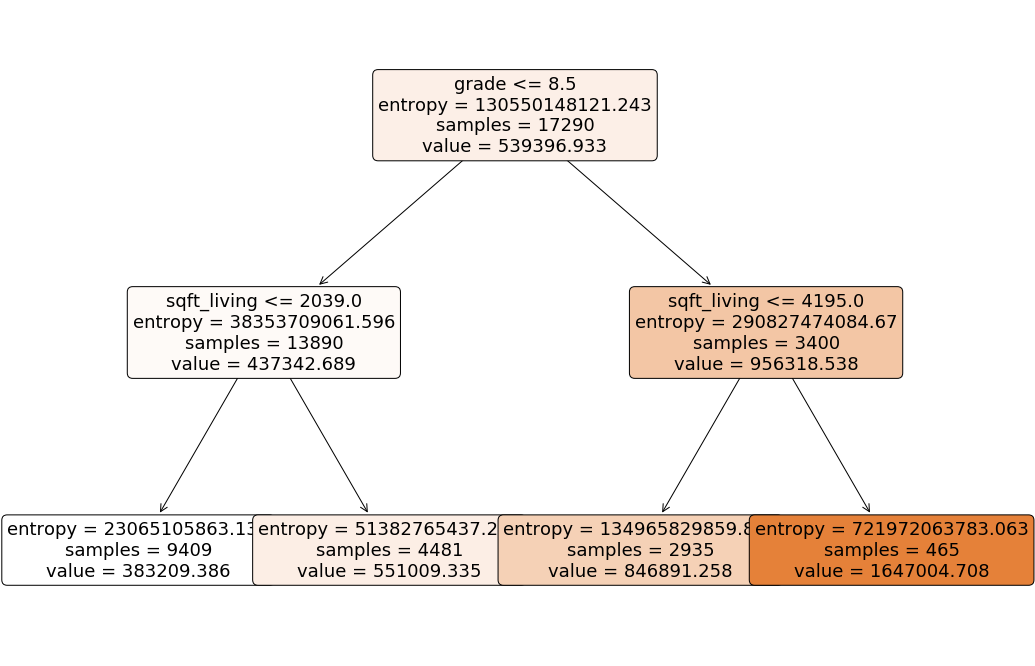

In [88]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(18,12))
res = plot_tree(
    dtree_5, 
    feature_names=most_important_feats, 
    rounded=True, 
    filled=True, 
    ax=ax,
    fontsize=18
)

### 5.8 Random Forests

In [89]:
from sklearn.ensemble import RandomForestRegressor
forest_regr = RandomForestRegressor(n_estimators=10) # new default numnber of estimators is 100 since 0.22
start = time.time()
cv_res = cross_validate(
    forest_regr,
    housing_num,
    housing_labels,
    scoring=['neg_mean_squared_error', 'r2'],
    cv=k_fold
)
end = time.time()
print("Duration: {} s".format(end - start))
cv_res

Duration: 10.621607303619385 s


{'fit_time': array([1.05, 1.04, 1.05, 1.04, 1.04, 1.05, 1.06, 1.06, 1.04, 1.05]),
 'score_time': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01]),
 'test_neg_mean_squared_error': array([-1.89e+10, -2.03e+10, -2.12e+10, -1.56e+10, -1.63e+10, -1.43e+10,
        -2.32e+10, -2.56e+10, -1.67e+10, -1.49e+10]),
 'test_r2': array([0.84, 0.87, 0.83, 0.86, 0.88, 0.89, 0.85, 0.82, 0.86, 0.86])}

In [90]:
forest_rmse_scores = np.sqrt(-cv_res['test_neg_mean_squared_error'])
display_scores(forest_rmse_scores)

Scores: [137549.8  142338.6  145635.65 124912.14 127856.53 119503.68 152467.53
 159886.38 129332.61 121906.94]
Mean: 136138.99
Standard deviation: 12966.98


## 6. Fine-tuning of your model

### 6.1 Grid Search 

In [91]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [3, 10, 30], 
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False], 
        'n_estimators': [3, 10], 
        'max_features': [2, 3, 4]
    },
]

forest_regr = RandomForestRegressor()
grid_search = GridSearchCV(
    forest_regr, param_grid, cv=5,
    scoring='neg_mean_squared_error', return_train_score=True
)

In [92]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


In [93]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [94]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [95]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(
    cv_res['mean_test_score'], 
    cv_res['params']
):
    print(np.sqrt(-mean_score), params)

179346.5895916858 {'max_features': 2, 'n_estimators': 3}
155123.98718800276 {'max_features': 2, 'n_estimators': 10}
145459.28980036298 {'max_features': 2, 'n_estimators': 30}
166340.9763555302 {'max_features': 4, 'n_estimators': 3}
143144.46775980416 {'max_features': 4, 'n_estimators': 10}
136536.44052067926 {'max_features': 4, 'n_estimators': 30}
156481.16822720098 {'max_features': 6, 'n_estimators': 3}
141094.5167928746 {'max_features': 6, 'n_estimators': 10}
131855.45396325135 {'max_features': 6, 'n_estimators': 30}
164633.86832314552 {'max_features': 8, 'n_estimators': 3}
134697.81347164052 {'max_features': 8, 'n_estimators': 10}
133730.62560424607 {'max_features': 8, 'n_estimators': 30}
177078.42815311445 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
148060.9708451551 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
162707.09059628315 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
144562.63626915877 {'bootstrap': False, 'max_features': 3, 'n_est

### 6.2 Randomized Search

From https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search

While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. `RandomizedSearchCV` implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:

* A budget can be chosen independent of the number of parameters and possible values.
* Adding parameters that do not influence the performance does not decrease efficiency.

Specifying how parameters should be sampled is done using a dictionary, very similar to specifying parameters for `GridSearchCV`.

### 6.3 Ensemble Methods

A possible way to fine tune your model is just to combine the models that perform best. You can get a good ensemble estimator out of a bunch of sloppy estimators. Random Forests are just an ensemble of Decision Trees trained on a random subset of the training set. Check the `sklearn.ensemble` module for more Ensemble Methods.

## 7. Evaluate Your System on the Test Set

After trying various your models and hyperparameter combinations you will eventually have an algorithm that performs sufficiently well. At this point the time comes to evaluate the final model on the test set. 

<b>Exercise 8:</b> Evaluate your best model on the test set we held out at the beginning of our analysis pipeline. What performance do you get? Is that what you expected?

In [96]:
# Write your code here


## 8. Deploy, Monitor, and Maintain Your System

At this stage you could think of wrapping the chosen model within a dedicated web service that your web application can access through a Web API. But this is the subject for another course!!

### This is the end of the demo for Week 3!!
See you next week